In [1]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from sklearn.metrics import accuracy_score, classification_report

In [110]:
# 1. Load Dataset
file_path = "D:/Tugas AI/data kami.csv"
dataset = pd.read_csv(file_path)

# Filter hanya data dengan Label = 1
# dataset= dataset[dataset['Label'] == 1]

# Ambil data Orang 1
kolom_data_ax1 = dataset['Ax1']
kolom_data_ay1 = dataset['Ay1']
kolom_data_az1 = dataset['Az1']

# Ambil data Orang 2
kolom_data_ax2 = dataset['Ax2']
kolom_data_ay2 = dataset['Ay2']
kolom_data_az2 = dataset['Az2']

# Hitung dan tampilkan nilai minimum dan maksimum
print("Orang 1:")
print("ax1 - Min:", kolom_data_ax1.min(), "| Max:", kolom_data_ax1.max())
print("ay1 - Min:", kolom_data_ay1.min(), "| Max:", kolom_data_ay1.max())
print("az1 - Min:", kolom_data_az1.min(), "| Max:", kolom_data_az1.max())

print("\nOrang 2:")
print("ax2 - Min:", kolom_data_ax2.min(), "| Max:", kolom_data_ax2.max())
print("ay2 - Min:", kolom_data_ay2.min(), "| Max:", kolom_data_ay2.max())
print("az2 - Min:", kolom_data_az2.min(), "| Max:", kolom_data_az2.max())

Orang 1:
ax1 - Min: -64.136 | Max: 49.5159
ay1 - Min: -47.9327 | Max: 15.0338
az1 - Min: -15.1671 | Max: 38.7498

Orang 2:
ax2 - Min: -50.7883 | Max: 65.5491
ay2 - Min: -59.0693 | Max: 22.2194
az2 - Min: -18.4048 | Max: 42.3343


In [111]:
# 2. Extract Sensor Values and True Labels
Ax1_vals = dataset.iloc[:, 1].values
Ay1_vals = dataset.iloc[:, 2].values
Az1_vals = dataset.iloc[:, 3].values
Ax2_vals = dataset.iloc[:, 4].values
Ay2_vals = dataset.iloc[:, 5].values
Az2_vals = dataset.iloc[:, 6].values
true_labels = dataset.iloc[:, -1].values

print(true_labels)

[0 0 0 ... 2 2 2]


In [112]:
# 3. Define Membership Ranges for Each Label
range_dict = {
    0: {  # Berputar
        'Ax1': (-64.136, 49.5159), 'Ay1': (-47.9327, 10.5016), 'Az1': (-12.7991, 38.7498),
        'Ax2': (-50.7883, 65.5491), 'Ay2': (-59.0693, -2.5409), 'Az2': (-13.1767, 42.3343),
    },
    1: {  # Berdiri
        'Ax1': (-23.9606, 37.9111), 'Ay1': (-28.3499, 15.0338), 'Az1': (-15.1671, 17.2101),
        'Ax2': (-26.9368, 20.8562), 'Ay2': (-28.3499, 22.2194), 'Az2': (-18.4048, 15.041),
    },
    2: {  # Duduk
        'Ax1': (-3.8479, 5.4633), 'Ay1': (-3.4649, 7.5147), 'Az1': (-7.6916, 20.0865),
        'Ax2': (-3.5721,  7.1441), 'Ay2': (-3.4344,  8.7644), 'Az2': (-8.0645, 13.6768),
    }
}

In [113]:
# 4. Membership Function Generator
def get_memberships(values, min_val, max_val):
    mid_val = (min_val + max_val) / 2
    return fuzz.trimf(values, [min_val, mid_val, max_val])

In [114]:
# 5. Fuzzification for Each Label
fuzzified = {}
for label in [0, 1, 2]:
    for axis in ['Ax1', 'Ay1', 'Az1', 'Ax2', 'Ay2', 'Az2']:
        min_val, max_val = range_dict[label][axis]
        fuzzified[f"{axis}_label{label}"] = get_memberships(eval(f"{axis}_vals"), min_val, max_val)

fuzzified_df = pd.DataFrame(fuzzified)

In [115]:
# 6. Inference (Using ax1, ay1, az1 Only for Simplicity)
def apply_rule(label_num):
    part1 = np.fmin(np.fmin(
        fuzzified_df[f"Ax1_label{label_num}"],
        fuzzified_df[f"Ay1_label{label_num}"]
    ), fuzzified_df[f"Az1_label{label_num}"])
    
    part2 = np.fmin(np.fmin(
        fuzzified_df[f"Ax2_label{label_num}"],
        fuzzified_df[f"Ay2_label{label_num}"]
    ), fuzzified_df[f"Az2_label{label_num}"])
    
    return np.fmin(part1, part2)

rule1 = apply_rule(0)
rule2 = apply_rule(1)
rule3 = apply_rule(2)

print(rule1)

0       0.299786
1       0.322516
2       0.327239
3       0.294002
4       0.200040
          ...   
2495    0.000000
2496    0.000000
2497    0.000000
2498    0.000000
2499    0.000000
Length: 2500, dtype: float64


In [116]:
# 7. Defuzzification and Output
sum_rules = rule1 + rule2 + rule3
sum_rules[sum_rules == 0] = 1e-6

# Gunakan bobot 0, 1, 2 karena itu label aslinya
crisp_output = (rule1 * 0 + rule2 * 1 + rule3 * 2) / sum_rules

# Tidak perlu tambah 1
predicted_label = np.round(crisp_output).astype(int)

# Pastikan hasil tetap dalam range 0–2
predicted_label = np.clip(predicted_label, 0, 2)

print(predicted_label)

0       0
1       0
2       0
3       0
4       0
       ..
2495    1
2496    1
2497    1
2498    1
2499    1
Length: 2500, dtype: int32


In [117]:
# 8. Save and Evaluate
hasil_akhir = dataset.copy()
hasil_akhir["prediksi_label"] = predicted_label
hasil_akhir.to_excel("hasil_prediksi_mamdani.xlsx", index=False)

print("Contoh hasil prediksi:")
print(hasil_akhir[["prediksi_label"]].head())

Contoh hasil prediksi:
   prediksi_label
0               0
1               0
2               0
3               0
4               0


In [118]:
# Evaluation
print("Akurasi:", accuracy_score(true_labels, predicted_label))
print(classification_report(true_labels, predicted_label))

Akurasi: 0.6684
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       669
           1       0.54      0.96      0.69       971
           2       1.00      0.08      0.15       860

    accuracy                           0.67      2500
   macro avg       0.83      0.68      0.60      2500
weighted avg       0.81      0.67      0.58      2500



In [130]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

true_label = dataset.iloc[:, -1].values # Ganti ini sesuai nama kolom label asli kamu
print(true_label)

[0 0 0 ... 2 2 2]


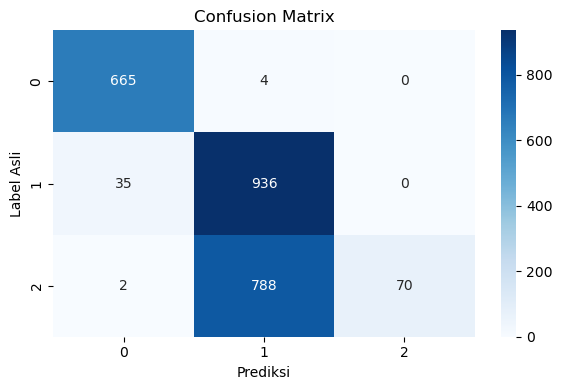

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       669
           1       0.54      0.96      0.69       971
           2       1.00      0.08      0.15       860

    accuracy                           0.67      2500
   macro avg       0.83      0.68      0.60      2500
weighted avg       0.81      0.67      0.58      2500



In [131]:
# Confusion matrix
cm = confusion_matrix(true_label, predicted_label)

# Tampilkan dengan heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=[0, 1, 2], yticklabels=[0, 1, 2])
plt.xlabel("Prediksi")
plt.ylabel("Label Asli")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

# Tampilkan laporan klasifikasi
print("Classification Report:")
print(classification_report(true_label, predicted_label))